# Convert SnowMIP forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## BERMS Old Black Spruce, Saskatchewan, Canada

Predominantly black spruce, with some tamarack, jack pine and balsam poplar, naturally
regenerated after fire in 1894. Sparse understorey. Peat soil over sandy loam and sand
with a raised water table.

| Short name | oas |
|:-----------|:----|
| Location | 53.99ºN, 105.12ºW |
| Elevation | 629 m |
| Canopy height | 11 m |
| Leaf area index | 3.5 – 3.8 |
| Snow-free albedo (above canopy) | 0.08 |
| Simulation period | 1 October 1997 to 30 September 2010 |
| Temperature/humidity measurement height | 25 m |
| Wind measurement height | 26 m |
| Reference | Bartlett et al. (2007) |

In [2]:
site = 'obs'

year_start = '1997'
year_end = '2010'

lat = 53.99
lon = -105.12

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/obs has been created!
/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/obs/forcing already exist.


### Open original forcing file

In [3]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 113952)
Coordinates:
  * time     (time) datetime64[ns] 1997-10-01T01:00:00 ... 2010-10-01
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

In [4]:
ds.time.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1048576,),
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/met_insitu_obs_1997_2010.nc',
 'original_shape': (113952,),
 'dtype': dtype('float32'),
 'units': 'hours since 1900-01-01 00:00:00.0'}

In [5]:
# Check if there are leap years
ds.sel(time='2004-02')

<xarray.Dataset>
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 2004-02-01 ... 2004-02-29T23:00:00
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

### Slice file to full years (as CLASSIC expect only full years)
It is not required as long as you only use the full years in the job file

In [6]:
year_start_full = str(int(year_start) + 1)
year_end_full = str(int(year_end) - 1)

ds_subset = ds.sel(time=slice(year_start_full, year_end_full))
ds_subset

<xarray.Dataset>
Dimensions:  (time: 105192)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 ... 2009-12-31T23:00:00
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

In [7]:
ds_subset.to_netcdf(path_tmp+'/met_insitu_'+site+'_'+year_start_full+'_'+year_end_full+'.nc')

### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [8]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_{year_start_full}_{year_end_full}.nc {path_tmp}/met_insitu_{site}_{year_start_full}_{year_end_full}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 841536 values from 8 variables over 105192 timesteps [13.44s 304MB]


## Open the new file with absolute time

In [9]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_'+year_start_full+'_'+year_end_full+'_a.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 105192)
Coordinates:
  * time     (time) float64 1.998e+07 1.998e+07 ... 2.009e+07 2.009e+07
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jan 30 09:13:30 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [10]:
ds.time

<xarray.DataArray 'time' (time: 105192)>
array([19980101.      , 19980101.041667, 19980101.083333, ..., 20091231.875   ,
       20091231.916667, 20091231.958333])
Coordinates:
  * time     (time) float64 1.998e+07 1.998e+07 ... 2.009e+07 2.009e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [11]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset>
Dimensions:  (time: 105192, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 1.998e+07 1.998e+07 ... 2.009e+07 2.009e+07
  * lon      (lon) float64 -105.1
  * lat      (lat) float64 53.99
Data variables:
    LWdown   (time, lat, lon) float32 251.0 248.9 246.1 ... 143.6 144.7 145.4
    Psurf    (time, lat, lon) float32 9.315e+04 9.32e+04 ... 9.586e+04 9.589e+04
    Qair     (time, lat, lon) float32 0.001156 0.001002 ... 0.000285 0.0002778
    Rainf    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float32 0.00027 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWdown   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair     (time, lat, lon) float32 259.0 257.5 256.2 ... 244.8 244.7 244.5
    Wind     (time, lat, lon) float32 4.175 3.6 2.345 2.43 ... 2.8 2.445 1.31
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jan 30 09:13:30 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

### Convert temperature to °C (<mark>required by CLASSIC</mark>)

In [12]:
with xr.set_options(keep_attrs=True):
    ds['Tair'] = ds['Tair'] - 273.15
    ds.Tair.attrs['units'] = '°C'
ds.Tair

<xarray.DataArray 'Tair' (time: 105192, lat: 1, lon: 1)>
array([[[-14.195007]],

       [[-15.674988]],

       [[-16.959991]],

       ...,

       [[-28.324997]],

       [[-28.434998]],

       [[-28.659988]]], dtype=float32)
Coordinates:
  * time     (time) float64 1.998e+07 1.998e+07 ... 2.009e+07 2.009e+07
  * lon      (lon) float64 -105.1
  * lat      (lat) float64 53.99
Attributes:
    long_name:  Near-surface air temperature
    units:      °C
    ALMA_name:  Tair
    CMIP_name:  ta

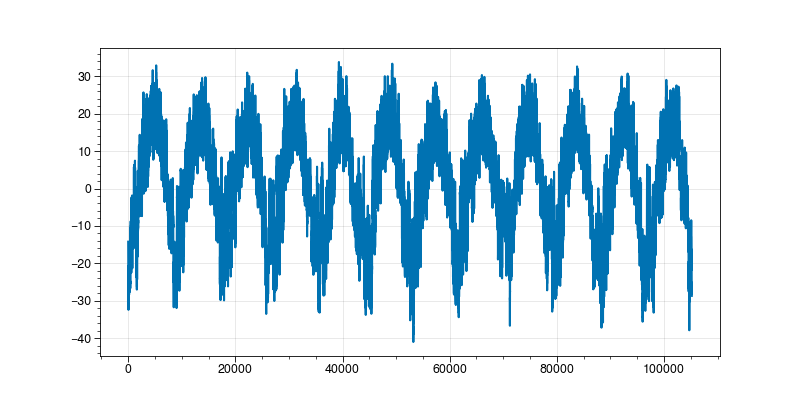

In [13]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

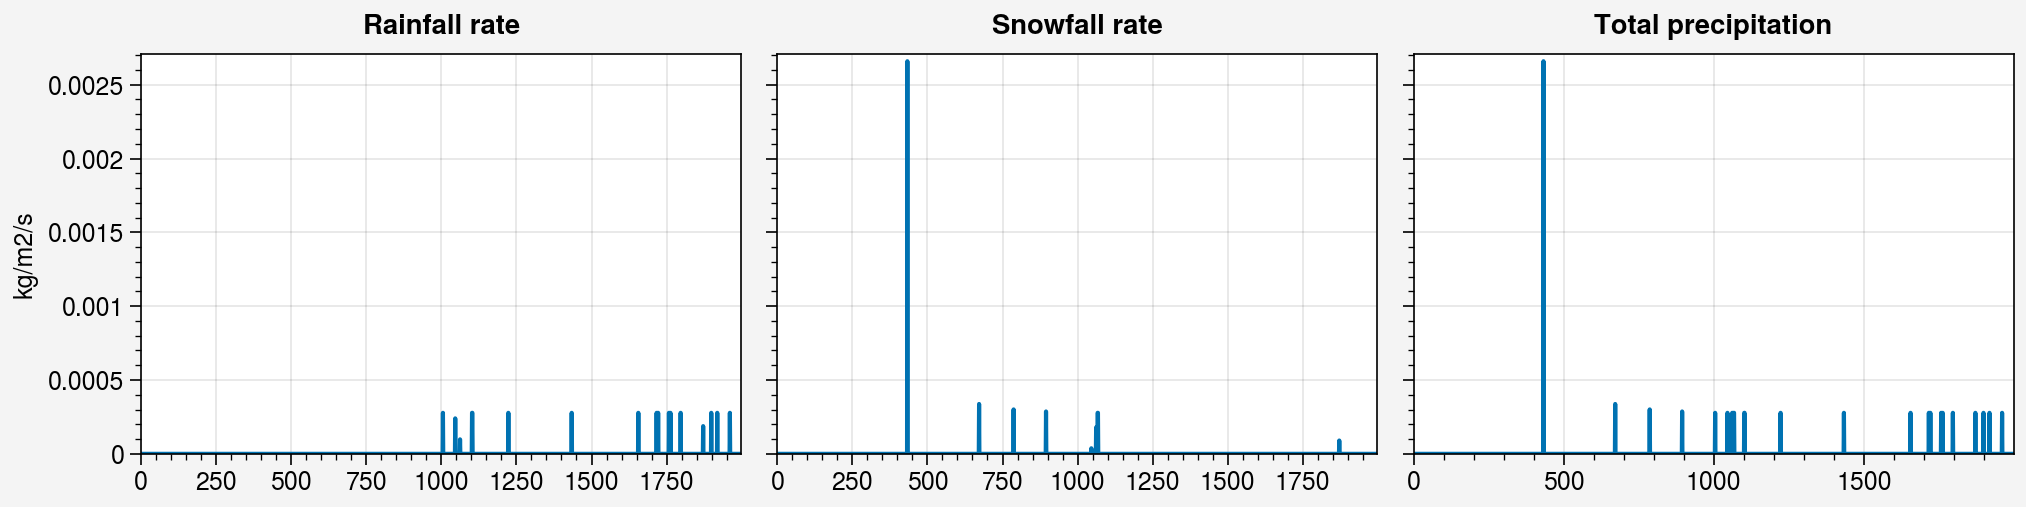

In [16]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 1000
i_end = 3000

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [17]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset>
Dimensions:    (time: 105192, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 1.998e+07 1.998e+07 ... 2.009e+07 2.009e+07
  * lon        (lon) float64 -105.1
  * lat        (lat) float64 53.99
Data variables:
    LWdown     (time, lat, lon) float32 251.0 248.9 246.1 ... 143.6 144.7 145.4
    Psurf      (time, lat, lon) float32 9.315e+04 9.32e+04 ... 9.589e+04
    Qair       (time, lat, lon) float32 0.001156 0.001002 ... 0.000285 0.0002778
    Rainf      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float32 0.00027 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWdown     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair       (time, lat, lon) float32 -14.2 -15.67 -16.96 ... -28.43 -28.66
    Wind       (time, lat, lon) float32 4.175 3.6 2.345 2.43 ... 2.8 2.445 1.31
    TotPrecip  (time, lat, lon) float32 0.00027 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jan 30 09:13:30 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [18]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')

In [19]:
!ls {path_out}

met_insitu_obs_1998_2009_LWdown.nc  met_insitu_obs_1998_2009_SWdown.nc
met_insitu_obs_1998_2009_Psurf.nc   met_insitu_obs_1998_2009_Tair.nc
met_insitu_obs_1998_2009_Qair.nc    met_insitu_obs_1998_2009_TotPrecip.nc
met_insitu_obs_1998_2009_Rainf.nc   met_insitu_obs_1998_2009_Wind.nc
met_insitu_obs_1998_2009_Snowf.nc


In [20]:
!ls {path_out_CLASSIC}

met_insitu_obs_1998_2009_LWdown.nc  met_insitu_obs_1998_2009_SWdown.nc
met_insitu_obs_1998_2009_Psurf.nc   met_insitu_obs_1998_2009_Tair.nc
met_insitu_obs_1998_2009_Qair.nc    met_insitu_obs_1998_2009_TotPrecip.nc
met_insitu_obs_1998_2009_Rainf.nc   met_insitu_obs_1998_2009_Wind.nc
met_insitu_obs_1998_2009_Snowf.nc
